<a href="https://colab.research.google.com/github/sha-doow/ML/blob/main/NN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16073430.15it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 511846.73it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3845248.77it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2115550.11it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
len(train_dataset)


60000

In [ ]:
len(test_dataset)

10000

In [ ]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[50000, 10000])

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

In [ ]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print("\nTraining label distribution:")
print(sorted(train_counter.items()))


val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())

print("\nValidation label distribution:")
print(sorted(val_counter.items()))


test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 4901), (1, 5591), (2, 4975), (3, 5146), (4, 4846), (5, 4515), (6, 4943), (7, 5228), (8, 4885), (9, 4970)]

Validation label distribution:
[(0, 1022), (1, 1151), (2, 983), (3, 985), (4, 996), (5, 906), (6, 975), (7, 1037), (8, 966), (9, 979)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


In [ ]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.11 (11.35%)


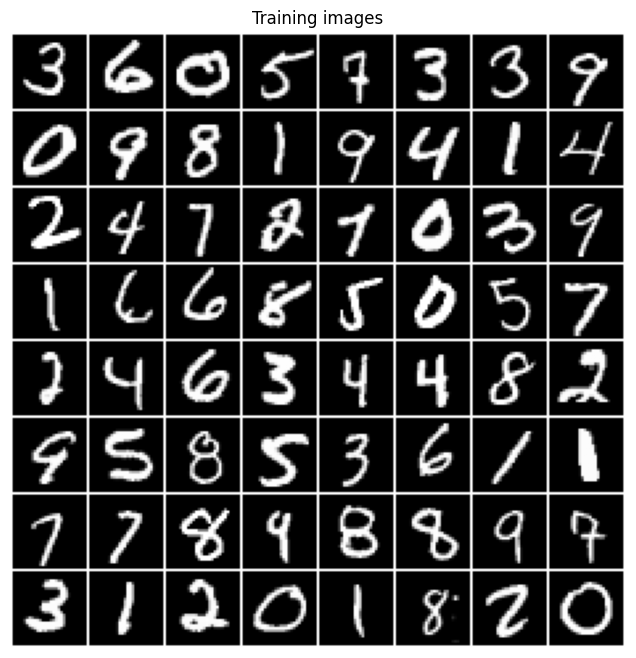

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [ ]:
images.shape # batchsize, channel, height, width

torch.Size([64, 1, 28, 28])

In [ ]:
import torch

torch.flatten(images, start_dim=1).shape # batchsize, features

torch.Size([64, 784])

In [ ]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [ ]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.inference_mode():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [ ]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/010 | Batch 000/782 | Train Loss: 2.31
Epoch: 001/010 | Batch 250/782 | Train Loss: 0.67
Epoch: 001/010 | Batch 500/782 | Train Loss: 0.43
Epoch: 001/010 | Batch 750/782 | Train Loss: 0.42
Train Acc 89.33% | Val Acc 89.35%
Epoch: 002/010 | Batch 000/782 | Train Loss: 0.45
Epoch: 002/010 | Batch 250/782 | Train Loss: 0.23
Epoch: 002/010 | Batch 500/782 | Train Loss: 0.27
Epoch: 002/010 | Batch 750/782 | Train Loss: 0.30
Train Acc 92.17% | Val Acc 91.90%
Epoch: 003/010 | Batch 000/782 | Train Loss: 0.33
Epoch: 003/010 | Batch 250/782 | Train Loss: 0.19
Epoch: 003/010 | Batch 500/782 | Train Loss: 0.18
Epoch: 003/010 | Batch 750/782 | Train Loss: 0.06
Train Acc 93.12% | Val Acc 92.57%
Epoch: 004/010 | Batch 000/782 | Train Loss: 0.14
Epoch: 004/010 | Batch 250/782 | Train Loss: 0.16
Epoch: 004/010 | Batch 500/782 | Train Loss: 0.24
Epoch: 004/010 | Batch 750/782 | Train Loss: 0.25
Train Acc 94.45% | Val Acc 93.78%
Epoch: 005/010 | Batch 000/782 | Train Loss: 0.20
Epoch: 005/010

In [ ]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 97.08%
Val Acc 95.75%
Test Acc 96.31%


In [ ]:
!pip install --user <package>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install --user <package>'


In [ ]:
!pip install helper_plotting


ERROR: Could not find a version that satisfies the requirement helper_plotting (from versions: none)
ERROR: No matching distribution found for helper_plotting


In [ ]:
import sys
sys.path.append("/path/to/helper_plotting")

from helper_plotting import plot_training_loss

plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(loss_list)//num_epochs)

ModuleNotFoundError: No module named 'helper_plotting'

In [ ]:
from helper_plotting import plot_accuracy

plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)

In [ ]:
from helper_plotting import show_examples


class_dict = {0: 'digit 0',
              1: 'digit 1',
              2: 'digit 2',
              3: 'digit 3',
              4: 'digit 4',
              5: 'digit 5',
              6: 'digit 6',
              7: 'digit 7',
              8: 'digit 8',
              9: 'digit 9'}

show_examples(
    model=model, data_loader=test_loader, class_dict=class_dict
)